# 07 - Além dos Confundidores

## Controles Eficazes

Já vimos como a adição de controles adicionais ao nosso modelo de regressão pode ajudar a identificar o efeito causal. Se o controle for uma variável confundidora, adicioná-lo ao modelo não é apenas algo bom de se fazer, mas uma exigência. Quando os incautos veem isso, a resposta natural é incluir tudo o que podem medir no modelo. No mundo atual de big data, isso poderia facilmente ultrapassar mais de 1000 variáveis. Como se constata, isso não apenas é desnecessário, mas pode ser prejudicial para a identificação causal. Agora, vamos direcionar nossa atenção para controles que não são variáveis confundidoras. Primeiro, vamos dar uma olhada nos bons controles. Depois, vamos aprofundar nos controles prejudiciais.

Como exemplo motivador, suponha que você seja um cientista de dados na equipe de cobranças de uma fintech. Sua próxima tarefa é entender o impacto do envio de um e-mail pedindo às pessoas que negociem suas dívidas. Sua variável de resposta é o valor dos pagamentos dos clientes em atraso.

Para responder a essa pergunta, sua equipe seleciona aleatoriamente 5000 clientes de sua base de clientes inadimplentes para realizar um teste aleatório. Para cada cliente, você joga uma moeda. Se der cara, o cliente recebe o e-mail; caso contrário, é deixado como controle. Com esse teste, você espera descobrir quanto dinheiro extra o e-mail gera.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

payments  email  opened  agreement  credit_limit  risk_score
0       740      1     1.0        0.0   2348.495260    0.666752
1       580      1     1.0        1.0    334.111969    0.207395
2       600      1     1.0        1.0   1360.660722    0.550479
3       770      0     0.0        0.0   1531.828576    0.560488
4       660      0     0.0        0.0    979.855647    0.455140

Dado que os dados são aleatórios, você sabe que uma simples diferença nas médias estima o Efeito Médio do Tratamento. Em outras palavras, nada pode ter causado o tratamento além da randomização, então os resultados potenciais são independentes do tratamento: $(Y_0, Y_1)\perp T$.

$
ATE = E[Y|T=1] - E[Y|T=0]
$

Como você é esperto e deseja construir um intervalo de confiança em torno de sua estimativa, você utiliza uma regressão linear.

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


<class 'statsmodels.iolib.table.SimpleTable'>

Infelizmente, o Efeito Médio do Tratamento estimado é -0.62, o que é bastante estranho. Como o envio de um e-mail pode fazer com que clientes inadimplentes paguem menos do que a média? Ainda assim, o valor-p é tão alto que isso provavelmente não significa nada. O que você deve fazer agora? Voltar para sua equipe de cabeça baixa e dizer que o teste é inconclusivo e que precisa de mais dados? Não tão rápido.

Observe como seus dados possuem outras colunas interessantes. Por exemplo, `credit_limit` representa o limite de crédito do cliente antes de ele ficar inadimplente. `risk_score` corresponde ao risco estimado do cliente antes do envio do e-mail. Faz sentido pensar que o limite de crédito e o risco são provavelmente bons preditores de pagamentos. Mas como isso pode ser útil?

Primeiro, vamos entender por que podemos falhar em encontrar significância estatística em um tratamento, mesmo quando ele está presente. Pode ser que, como neste caso, o tratamento tenha muito pouco impacto no resultado. Se você pensar a respeito, o que leva as pessoas a pagarem suas dívidas são, em grande parte, fatores fora do controle do departamento de cobranças. As pessoas pagam suas dívidas porque conseguem um novo emprego, gerenciam suas finanças, têm renda, e assim por diante. Em termos estatísticos, podemos dizer que **a variabilidade dos pagamentos é explicada muito mais por outros fatores do que pelo e-mail**.

Para obter uma compreensão visual disso, podemos plotar os pagamentos em relação à variável de tratamento email. Também plotamos a linha ajustada do modelo acima em vermelho. Para auxiliar na visualização, adicionei um pouco de ruído à variável email para que ela não fique concentrada em zero ou um.

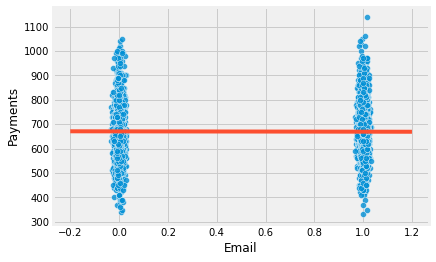

In [4]:
sns.scatterplot(x="email", y="payments", 
                alpha=0.8,
                data=data.assign(email=data["email"] + np.random.normal(0, 0.01, size=len(data["email"]))))
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");

Podemos observar como os pagamentos variam drasticamente em um único grupo de tratamento. Visualmente, parece que estão oscilando de um pouco abaixo de 400 a 1000 em ambos os grupos. Se o impacto do e-mail estiver na ordem de, digamos, 5,00 ou 10,00 R$, não é de surpreender que seja difícil identificá-lo em meio a toda essa variabilidade.

Felizmente, a regressão pode nos ajudar a reduzir essa variabilidade. O truque é usar controles adicionais. **Se uma variável é um bom preditor do resultado, ela explicará grande parte de sua variância**. Se o risco e o limite de crédito são bons preditores de pagamento, podemos controlá-los para facilitar a identificação do impacto do e-mail nos pagamentos. Se lembrarmos como a regressão funciona, isso tem uma explicação intuitiva. Adicionar variáveis extras a uma regressão significa mantê-las constantes ao analisar o tratamento. Portanto, o raciocínio é o seguinte: se olharmos para níveis semelhantes de risco e limite de crédito, a variância da variável de resposta `payments` deve ser menor. Ou, em outras palavras, se o risco e o limite de crédito preveem muito bem os pagamentos, clientes com risco e limite de crédito semelhantes também devem ter níveis de pagamento semelhantes, portanto, com menos variabilidade.

![img](./data/img/beyond-conf/y-pred.png)

Para demonstrar isso, recorreremos à abordagem de separar a regressão em 2 etapas. Primeiro, vamos regredir o tratamento, email, e o resultado, pagamentos, nos controles adicionais, limite de crédito e pontuação de risco. Em segundo lugar, vamos regredir o resíduo do tratamento nos resíduos dos pagamentos, ambos obtidos na etapa 1. (Isso é puramente pedagógico, na prática você não precisará passar por toda essa complicação).

In [5]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

Isso reduz a variância da variável dependente. Ao regredir os pagamentos no limite de crédito e no risco e obter os resíduos para este modelo, estamos criando uma nova variável dependente com muito menos variabilidade do que a original. O último modelo também revela o `ATE` com uma estimativa válida do erro padrão.

Apenas por curiosidade, também podemos verificar que o modelo que prevê o tratamento não deve ser capaz de reduzir a variância. Isso ocorre porque o e-mail é, por design, aleatório, então nada pode prevê-lo.

In [6]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.612416
Payments Residual Variance 5652.453558466207
Email Variance 0.24991536
Email Residual Variance 0.24918421069820032


<class 'statsmodels.iolib.table.SimpleTable'>

Observe como a variância dos pagamentos foi de 10807 para 5652. Reduzimos pela metade praticamente ao controlar o risco e os limites de crédito. Observe também que não conseguimos reduzir a variabilidade do tratamento, e-mail. Isso faz sentido, uma vez que risco e limite de crédito não prevêem o e-mail (nada prevê, por definição de aleatoriedade).

Agora, vemos algo muito mais razoável. Essa nova estimativa nos diz que devemos esperar que os clientes que receberam o e-mail paguem, em média, 4,4 reais a mais do que aqueles no grupo de controle. Essa estimativa agora é estatisticamente diferente de zero. Também podemos visualizar como a variância é agora menor dentro de cada grupo de controle.

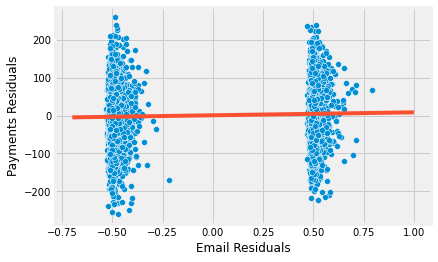

In [7]:
sns.scatterplot(x="res_email", y="res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

Como mencionei, fizemos isso por razões pedagógicas. Na prática, você pode simplesmente adicionar os controles ao modelo de regressão juntamente com o tratamento, e as estimativas serão exatamente as mesmas.

In [8]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Para resumir, sempre que temos um controle que é um bom preditor do resultado, mesmo que não seja um fator de confusão, adicioná-lo ao nosso modelo é uma boa ideia. Isso ajuda a diminuir a variância de nossas estimativas de efeito do tratamento. Aqui está uma representação gráfica de como essa situação se parece com gráficos causais.

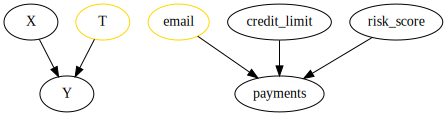

In [9]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## Controles Majoritariamente Prejudiciais

Como segundo exemplo motivador, consideremos um cenário de teste de medicamento com dois hospitais. Ambos estão conduzindo ensaios randomizados com um novo medicamento para tratar uma determinada doença. O resultado de interesse é o número de dias hospitalizado. Se o tratamento for eficaz, ele reduzirá a quantidade de dias que o paciente passa no hospital. Para um dos hospitais, a política em relação ao tratamento randomizado é administrá-lo a 90% de seus pacientes, enquanto 10% recebem um placebo. O outro hospital tem uma política diferente: ele administra o medicamento a 10% aleatórios de seus pacientes, e 90% recebem um placebo. Você também é informado de que o hospital que administra 90% do verdadeiro medicamento e 10% do placebo geralmente trata casos mais graves da doença.

In [10]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

hospital  treatment   severity  days
0         1          1  29.686618    82
1         1          1  20.050340    57
2         1          1  20.302399    49
3         0          0  10.603118    44
4         0          0   8.332793    15

Como você está lidando com dados randomizados, seu primeiro instinto é simplesmente realizar uma regressão do resultado sobre o tratamento.

In [11]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Mas você encontra alguns resultados contraditórios. Como o tratamento pode estar aumentando o número de dias no hospital? A resposta reside no fato de estarmos realizando dois experimentos diferentes. A gravidade está positivamente relacionada com mais dias no hospital e, como o hospital com casos mais graves também fornece mais do medicamento, o medicamento se torna positivamente correlacionado com mais dias no hospital. Quando olhamos para ambos os hospitais juntos, temos que $E[Y_0|T=0]<E[Y_0|T=1]$, ou seja, o resultado potencial dos não tratados é, em média, menor do que o dos tratados porque há mais não tratados no hospital com casos menos graves. Em outras palavras, a gravidade atua como um fator de confusão, determinando o hospital para o qual o paciente vai e, portanto, a probabilidade de receber o medicamento.

Existem duas maneiras de corrigir isso. A primeira, que vai contra o propósito de usar dados de ambos os hospitais, é simplesmente analisar o ATE em cada hospital individualmente.

In [12]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [13]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Neste caso, obtivemos um resultado intuitivo do ATE. Parece que agora o medicamento está, de fato, reduzindo a quantidade de dias no hospital. No entanto, como estamos olhando para cada hospital individualmente, não há pontos de dados suficientes. Como consequência, não conseguimos encontrar resultados estatisticamente significativos.

A outra abordagem, que aproveita o poder da regressão, é controlar a gravidade incluindo-a no modelo.

In [14]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

A próxima pergunta que surge é: devemos também incluir o hospital no modelo? Afinal, sabemos que os hospitais causam o tratamento, certo? Bem, isso é verdade, mas uma vez que controlamos a gravidade, o hospital não está mais correlacionado com o resultado número de dias hospitalizado. E sabemos que, para ser confundidora, uma variável tem que causar tanto o tratamento quanto o resultado. Neste caso, temos uma variável que só causa o tratamento.

Mas talvez controlar isso reduza a variância, certo? Bem, também não é verdade. Para que um controle reduza a variância, ele precisa ser um bom preditor do resultado, não do tratamento, o que não é o caso aqui.

Mesmo assim, podemos querer controlá-lo, certo? Não custa nada... Ou custa?

In [15]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Supreendentemente, isso pode custar!

![img](./data/img/beyond-conf/shocked.png)

Adicionar o hospital além da gravidade como controle introduziu MAIS variância ao nosso estimador de ATE. Como isso é possível? A resposta está na fórmula para o erro padrão do coeficiente de regressão.

$
\hat{\sigma}^2 = \dfrac{1}{n-2} \sum( y_i - \hat{y}_i )^2
$

$
\text{Var}(\hat{\beta}_2) = \dfrac{\sigma^2}{\sum(x_i - \bar{x})^2}
$

A partir desta fórmula, podemos ver que o erro padrão é inversamente proporcional à variância da variável $X$. Isso significa que, se $X$ não variar muito, será difícil estimar seu efeito sobre o resultado. Isso também faz sentido intuitivo. Leve ao extremo e imagine que você queira estimar o efeito de um medicamento, então você realiza um teste com 10.000 indivíduos, mas apenas 1 deles recebe o tratamento. Isso tornará muito difícil encontrar o ATE, teremos que depender da comparação de um único indivíduo com todos os outros. Outra forma de dizer isso é que precisamos de muita variabilidade no tratamento para facilitar a identificação de seu impacto.

Quanto ao motivo pelo qual incluir hospitais no modelo aumenta o erro da nossa estimativa, é porque ele é um bom preditor do tratamento e não do resultado (quando controlamos a gravidade). Assim, ao prever o tratamento, efetivamente faz com que sua variância seja menor! Mais uma vez, podemos recorrer à divisão da nossa regressão em suas duas etapas para ver isso.

In [16]:
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [17]:
print("Treatment Variance", np.var(hospital["treatment"]))
print("Treatment Residual Variance", np.var(residuals["res_treatment"]))

Treatment Variance 0.234375
Treatment Residual Variance 0.05752909187211906


Além disso, não acredite apenas em mim! Você pode verificar se a fórmula de erro padrão acima é verdadeira:

In [18]:
sigma_hat = sum(model_treatment.resid**2)/(len(model_treatment.resid)-2)
var = sigma_hat/sum((residuals["res_treatment"] - residuals["res_treatment"].mean())**2)
print("SE of the Coeficient:", np.sqrt(var))

SE of the Coeficient: 3.446973767486901


Portanto, a conclusão é que devemos adicionar controles que são tanto correlacionados com o tratamento quanto com o resultado (confundidores), como a gravidade no modelo acima. Também devemos adicionar controles que são bons preditores do resultado, mesmo que não sejam confundidores, porque eles reduzem a variância de nossas estimativas. No entanto, **NÃO** devemos adicionar controles que são apenas bons preditores do tratamento, pois aumentarão a variância de nossas estimativas.

Aqui está uma representação gráfica de como essa situação se parece com gráficos causais.

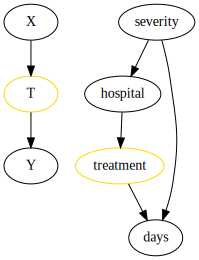

In [19]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

## Controles Inadequados - Viés de Seleção

Vamos voltar ao exemplo do e-mail de cobrança. Lembre-se de que o e-mail foi atribuído aleatoriamente aos clientes. Já explicamos o que é `credit_limit` e `risk_score`. Agora, vamos olhar para as variáveis restantes. `opened` é uma variável dummy para o cliente abrir ou não o e-mail. `agreement` é outra dummy que marca se os clientes entraram em contato com o departamento de cobranças para negociar sua dívida após receberem o e-mail. Qual dos seguintes modelos você acha mais apropriado? O primeiro é um modelo com a variável de tratamento mais `credit_limit` e `risk_score`; o segundo adiciona as dummies `opened` e `agreement`.

In [20]:
email_1 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
email_1.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [21]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Embora o primeiro modelo encontre resultados estatisticamente significativos para o e-mail, o segundo não. Mas talvez o segundo seja o modelo correto e não haja efeito para o e-mail. Afinal, este modelo controla mais fatores, então deveria ser mais robusto, certo? Neste ponto, você provavelmente sabe que esse não é o caso. O que resta é descobrir o que é.

Sabemos que DEVEMOS adicionar variáveis de confusão. Variáveis que causam tanto o tratamento quanto o resultado. Também sabemos que é uma boa ideia adicionar controles que preveem muito bem o resultado. Isso não é obrigatório, mas é bom ter. Também sabemos que é uma má ideia adicionar controles que preveem apenas o tratamento. Novamente, isso não é um pecado mortal, mas é bom evitar. Então, que tipo de controles são `opened` e `agreement`? Acontece que elas não se encaixam em nenhuma das categorias acima.

Se você pensar sobre isso, `opened` e `agreement` estão certamente correlacionadas com o e-mail. Afinal, você não pode abrir o e-mail se não o recebeu, e também afirmamos que o acordo só considera renegociações que aconteceram após o envio do e-mail. Mas **elas não causam o e-mail! Em vez disso, são causadas por ele!**

Sempre que preciso entender que tipo de variáveis estou lidando, gosto de pensar em seu gráfico causal. Vamos fazer isso aqui.

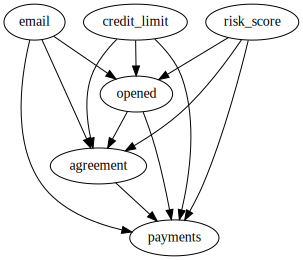

In [22]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

Sabemos que nada causa o e-mail, porque ele é aleatório por design. E sabemos (ou pelo menos temos fortes motivos para acreditar) que o limite de crédito e o risco causam pagamentos. Também acreditamos que o e-mail causa pagamentos. Quanto a `opened`, acreditamos que ela causa pagamentos. Intuitivamente, as pessoas que abriram o e-mail de cobrança estão mais dispostas a negociar e pagar suas dívidas. Também acreditamos que `opened` causa acordos pelas mesmas razões que ela causa pagamentos. Além disso, sabemos que `opened` é causada pelo e-mail e temos motivos para acreditar que pessoas com diferentes riscos e limites de crédito têm diferentes taxas de abertura para os e-mails, então o limite de crédito e o risco também causam `opened`. Quanto ao acordo, também acreditamos que ele é causado por `opened`. Se pensarmos na variável de resposta pagamentos, podemos imaginá-la como o resultado de um funil:

$
email -> opened -> agreement -> payment 
$

Também acreditamos que diferentes níveis de risco e limite de crédito têm diferentes propensões a fazer um acordo, então os marcamos como também causando um acordo. Quanto ao e-mail e ao acordo, poderíamos argumentar que algumas pessoas apenas leem o assunto do e-mail e isso as torna mais propensas a fazer um acordo. O ponto é que o e-mail também poderia causar um acordo sem passar pela abertura.

O que percebemos com este gráfico é que `opened` e `agreement` estão ambos no caminho causal do e-mail para pagamentos. Portanto, se controlarmos por eles com regressão, estaríamos dizendo "este é o efeito do e-mail mantendo `opened` e `agreement` fixos". No entanto, ambos fazem parte do efeito causal do e-mail, então não queremos mantê-los fixos. Em vez disso, poderíamos argumentar que o e-mail aumenta os pagamentos precisamente porque impulsiona a taxa de acordos. Se fixarmos essas variáveis, estamos removendo parte do verdadeiro efeito da variável de e-mail.

Com a notação de resultados potenciais, podemos dizer que, devido à randomização, $E[Y_0|T=0] = E[Y_0|T=1]$. No entanto, mesmo com randomização, quando controlamos por acordo, tratamento e controle não são mais comparáveis. Na verdade, com algum pensamento intuitivo, até podemos imaginar como eles são diferentes:

$
E[Y_0|T=0, Agreement=0] > E[Y_0|T=1, Agreement=0]
$

$
E[Y_0|T=0, Agreement=1] > E[Y_0|T=1, Agreement=1]
$

A primeira equação deixa explícito que pensamos que aqueles sem o e-mail e sem o acordo são melhores do que aqueles com o e-mail e sem o acordo. Isso ocorre porque, se o tratamento tem um efeito positivo, aqueles que não fizeram um acordo **mesmo depois de receber o e-mail** provavelmente são piores em termos de pagamentos em comparação com aqueles que também não fizeram o acordo, mas também não receberam o incentivo extra do e-mail. Quanto à segunda equação, aqueles que fizeram o acordo mesmo sem terem recebido o tratamento são provavelmente melhores do que aqueles que fizeram o acordo, mas tiveram o incentivo extra do e-mail.

Isso pode ser muito confuso na primeira leitura (foi para mim), mas certifique-se de entendê-lo. Leia novamente, se necessário. Em seguida, um raciocínio semelhante pode ser feito com a variável `opened`. Tente fazê-lo por conta.

Esse tipo de viés é tão difundido que tem seu próprio nome. Enquanto o confundidor é o viés resultante da falha em controlar uma causa comum, **o viés de seleção ocorre quando controlamos um efeito comum ou uma variável no caminho entre a causa e o efeito.** Como regra prática, sempre inclua variáveis confundidoras e variáveis que são boas preditoras de $Y$ em seu modelo. Sempre exclua variáveis que são boas preditoras apenas de $T$, mediadores entre o tratamento e o resultado ou efeito comum do tratamento e resultado.

![img](./data/img/beyond-conf/selection.png)

O viés de seleção é tão difundido que nem mesmo a randomização pode corrigi-lo. Pior ainda, muitas vezes é introduzido por conselhos mal orientados, mesmo em dados aleatórios! Identificar e evitar o viés de seleção requer mais prática do que habilidade. Muitas vezes, ele aparece sob alguma ideia supostamente inteligente, tornando ainda mais difícil descobrir. Aqui estão alguns exemplos de viés de seleção que encontrei:

    1. Adicionando uma variável dummy por pagar toda a dívida ao tentar estimar o efeito de uma estratégia de cobrança nos pagamentos.
    2. Controlando por trabalhos de emprego executivo versus braçal ao tentar estimar o efeito da escolaridade nos ganhos.
    3. Controlando por conversão ao estimar o impacto das taxas de juros na duração do empréstimo.
    4. Controlando por felicidade conjugal ao estimar o impacto dos filhos em casos extraconjugais.
    5. Dividindo o modelo de pagamentos E[Pagamentos] em um modelo binário que prevê se o pagamento ocorrerá e outro modelo que prevê quanto pagamento ocorrerá, dado que algum pagamento acontecerá: E[Pagamentos|Pagamentos>0]*P(Pagamentos>0).
    
O que é notável sobre todas essas ideias é como parecem razoáveis. O viés de seleção muitas vezes soa razoável. Que isso sirva de aviso. Na verdade, eu mesmo caí nas armadilhas acima muitas, muitas vezes antes de aprender o quão ruins elas eram. Um em particular, o último, merece uma explicação mais detalhada porque parece tão inteligente e pega muitos cientistas de dados desprevenidos. É tão difundido que tem seu próprio nome: **Mau COP (Bad COP)**.


### Mau COP

A situação é a seguinte. Você tem uma variável contínua que deseja prever, mas sua distribuição é superrepresentada em zero. Por exemplo, se você deseja modelar os gastos do consumidor, terá algo como uma distribuição gama, mas com muitos zeros.

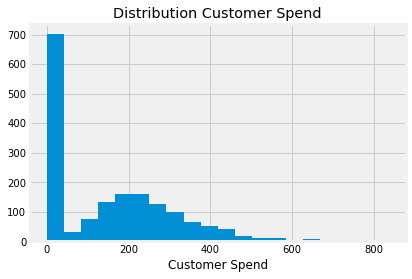

In [23]:
plt.hist(np.concatenate([
    np.random.gamma(5, 50, 1000), 
    np.zeros(700)
]), bins=20)
plt.xlabel("Customer Spend")
plt.title("Distribution Customer Spend");

Quando um cientista de dados vê isso, a primeira ideia que lhe vem à mente é dividir o modelo em 2 etapas. A primeira é a participação, ou seja, a probabilidade de $Y > 0$. No nosso exemplo de gastos, isso seria modelar se o cliente decide gastar ou não. A segunda parte modela $Y$ para aqueles que decidiram participar. É o efeito Condicional-em-Positivos *(COP, do inglês "conditional-on-positive")*. No nosso caso, seria quanto o cliente gasta depois de decidir que gastaria alguma coisa. Se quisermos estimar o efeito do tratamento $T$ nos gastos, ficaria algo assim:
 
$
E[Y|T] = E[Y|Y>0, T]P(Y>0|T)
$
 
Não há nada de errado com o modelo de participação $P(Y_i>0|T_i)$. Na verdade, se $T$ for atribuído aleatoriamente, ele capturará o aumento na probabilidade de gastar devido ao tratamento. Além disso, não há nada de errado com a decomposição acima. É matematicamente verdadeira, pela lei das probabilidades totais.
 
O problema está em estimar a parte COP. **Ela será enviesada mesmo sob atribuição aleatória**. Em um nível intuitivo, não é loucura pensar que algumas unidades são zeros apenas porque não receberam o tratamento. O tratamento faria com que eles **não** fossem zeros. Por outro lado, algumas unidades nunca são zeros. O tratamento pode aumentar o resultado delas, mas mesmo sem ele, elas não seriam zeros. Agora, o ponto chave é entender que esses dois tipos de unidades não são comparáveis. Aqueles que nunca são zeros têm um $Y_0$ alto em comparação com aqueles que são zeros se não receberem o tratamento. Na verdade, para estes últimos, $Y_0=0$.
 
Sabendo disso, se removermos os zeros, manteremos os que nunca são zeros tanto no grupo tratado quanto no grupo de controle. Mas removeríamos do grupo de controle aqueles que mudam de zero para não zero com o tratamento. Isso faria com que o tratamento e o controle não fossem mais comparáveis, porque o controle conteria apenas aqueles que nunca são zeros e que têm $Y_0$ mais alto, enquanto o tratado conteria ambos os tipos de unidades.

Agora que temos uma compreensão intuitiva do problema, vamos verificar isso do ponto de vista matemático. Para ver isso, vamos dividir o efeito do tratamento. Sob atribuição aleatória, é igual à diferença nas médias.
 
$$
\begin{align*} 
&E[Y|T=1] - E[Y|T=0]\\
&=E[Y|Y>0, T=1]P(Y>0|T=1) - E[Y|Y>0, T=0]P(Y>0|T=0)\\
&=\underbrace{\{P(Y>0|T=1) - P(Y>0|T=0)\}}_{Participation \ Effect} * E[Y|Y>0, T=1]\\
&+\underbrace{\{E[Y|Y>0, T=1] - E[Y|Y>0, T=0]\}}_{COP \ Effect} * P(Y>0|T=0)
\end{align*} 
$$
 
A última igualdade vem da adição e subtração de $E[Y_i|Y_i>0, T_i=1]P(Y_i>0|T_i=0)$ e rearranjo dos termos. Isso significa que a diferença nas médias é composta por duas partes: primeiro, é a diferença na probabilidade de que o resultado $y$ seja positivo. Isso é chamado de efeito de participação porque mede o aumento na probabilidade de os clientes participarem dos gastos. Segundo, é a diferença no resultado condicionado à participação, o efeito COP. Até aqui tudo bem. Não há nada de errado com isso. É uma verdade matemática. O problema surge quando tentamos estimar cada parte separadamente.

Isso se torna mais evidente se analisarmos o efeito COP ainda mais a fundo.
 
$$
\begin{align*} 
E[Y|Y>0, T=1] - E[Y|Y>0, T=0]&=E[Y_{1}|Y_{1}>0]-E[Y_{0}|Y_{0}>0] \\
&=\underbrace{E[Y_{1} - Y_{0}|Y_{1}>0]}_{Causal \ Effect} + \underbrace{\{ E[Y_{0}|Y_{1}>0] - E[Y_{0}|Y_{0}>0] \}}_{Selection \ Bias}
\end{align*} 
$$
 
onde a segunda igualdade vem depois de adicionarmos e subtrairmos $E[Y_{i0}|Y_{i1}>0]$. Quando dividimos o efeito COP, obtemos primeiro o efeito causal na subpopulação de participantes. Em nosso exemplo, isso seria o efeito causal naqueles que decidem gastar algo. Em segundo lugar, obtemos um termo de viés que é a diferença em $Y_0$ para aqueles que decidem participar quando atribuídos ao tratamento ($E[Y_{i0}|Y_{i1}>0]$) e aqueles que participam mesmo sem o tratamento ($E[Y_{i0}|Y_{i0}>0]$). Em nosso caso, esse viés provavelmente é negativo, pois aqueles que gastam quando atribuídos ao tratamento, caso não recebessem o tratamento, provavelmente gastariam menos do que aqueles que gastam mesmo sem o tratamento $E[Y_{i0}|Y_{i1}>0] < E[Y_{i0}|Y_{i0}>0]$.
 
![img](./data/img/beyond-conf/cop.png)
 
Agora, eu sei que o viés COP é supercontraintuitivo no início, então acho que vale a pena passar por um exemplo visual. Digamos que queremos estimar como uma campanha de marketing aumenta os gastos das pessoas em nosso produto. Essa campanha de marketing foi randomizada, então não precisamos nos preocupar com confundimento. Neste exemplo, podemos dividir os clientes em dois segmentos. Primeiro, há aqueles que só comprarão nossos produtos se virem uma campanha de marketing. Vamos chamá-los de clientes frugais. Eles não gastam a menos que lhes demos um impulso extra. Em seguida, há os clientes que gastarão mesmo sem a campanha. A campanha faz com que gastem mais, mas eles já gastariam mesmo sem vê-la. Vamos chamá-los de clientes ricos. Na figura, eu exibi os contrafactuais em cores claras e linhas tracejadas.
 
![img](./data/img/beyond-conf/cop-ex1.png)
 
Para estimar o ATE da campanha, como temos randomização, tudo o que precisamos fazer é comparar os tratados com os não tratados. Mas, suponha que usemos a formulação COP, onde dividimos a estimativa em dois modelos, um modelo de participação que estima $P(Y_i>0|T_i)$ e o COP, que estima $E[Y_i|Y_i>0]$. Isso remove todos que não gastaram da análise.
 
![img](./data/img/beyond-conf/cop-ex2.png)
 
Quando fazemos isso, os tratados e não tratados não são mais comparáveis. Como podemos ver, os não tratados agora são compostos apenas pelo segmento de clientes que gastarão mesmo sem a campanha. Observe também que podemos até mesmo saber a direção do viés aqui. Será $E[Y_{i0}|Y_{i1}>0] - E[Y_{i0}|Y_{i0}>0]$ ou $E[Y_{i0}|\text{Frugal and Rich}] - E[Y_{i0}|Rich]$. Isso é obviamente negativo, já que os clientes ricos gastam mais do que os clientes econômicos. Como resultado, uma vez que filtramos apenas a população de participantes, nossa estimativa do ATE se torna enviesada, mesmo que não houvesse viés a princípio devido à randomização. Espero sinceramente que isso o convença a evitar o COP como a peste. Vejo muitos cientistas de dados fazendo essa estimativa separada, sem estar ciente dos problemas que ela traz.

Para concluir o viés de seleção, precisamos sempre nos lembrar de nunca controlar uma variável que esteja entre o tratamento e o resultado ou que seja um efeito comum do resultado e do tratado. Em linguagem gráfica, é assim que se parece um controle ruim:

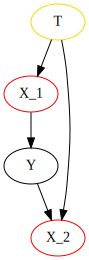

In [24]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g

## Conceitos-chave

Nesta seção, examinamos variáveis que não são confundidoras e se devemos ou não adicioná-las ao nosso modelo para identificação causal. Vimos que variáveis que são boas preditoras do resultado $y$ devem ser adicionadas ao modelo, mesmo que não predigam $T$ (não sejam confundidoras). Isso ocorre porque prever $Y$ reduz sua variância e torna mais provável que vejamos resultados estatisticamente significativos ao estimar o efeito causal. Em seguida, vimos que é uma má ideia adicionar variáveis que preveem o tratamento, mas não o resultado. Essas variáveis reduzem a variabilidade do tratamento, tornando mais difícil encontrar o efeito causal. Finalmente, examinamos o viés de seleção. Este é um viés que surge quando controlamos variáveis no caminho causal do tratamento para o resultado ou variáveis que são efeitos comuns do tratamento e do resultado.

## Referências

Gosto de pensar nesta série inteira como uma homenagem a Joshua Angrist, Alberto Abadie e Christopher Walters por sua incrível aula de Econometria. A maioria das ideias aqui foram tiradas de suas aulas na *American Economic Association*. Assisti-las é o que está me mantendo são durante este difícil ano de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Também gostaria de referenciar os livros incríveis de Angrist. Eles me mostraram que Econometria, ou 'Métricas, como eles chamam, não é apenas extremamente útil, mas também profundamente divertida.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Finalmente, gostaria de referenciar o livro de Miguel Hernan e Jamie Robins. Tem sido meu fiel companheiro nas questões mais espinhosas de inferência causal que tive que responder.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribua

"Inferência Causal para os Corajosos e Verdadeiros" é um material de código aberto sobre inferência causal, a estatística da ciência. Seu objetivo é ser acessível monetariamente e intelectualmente. Ele utiliza apenas software gratuito baseado em Python.
Se você encontrou valor neste livro e deseja apoiá-lo, por favor, vá para o [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Se você não estiver pronto para contribuir financeiramente, também pode ajudar corrigindo erros, sugerindo edições ou dando feedback sobre trechos que não compreendeu. Acesse o repositório do livro e abra uma issue na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/issues) ou na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/issues). Por fim, se você gostou deste conteúdo, compartilhe com outras pessoas que possam achar útil e dê uma estrela no GitHub na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/stargazers) e na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/stargazers).

---

<em> <b>Nota de Tradução:</b> COP é acrônimo de Conditional-On-Positive. Ao nomearem o viés como Bad COP em seu livro Mostly Harmless Econometrics, Angrist-Pischke fazem um trocadilho com o termo "the good cop, bad cop aproach", visto geralmente em filmes no momento em que dois policiais usam táticas opostas para interrogar um suspeito.</em>

<div align="center">
<a href="06-Grouped-and-Dummy-Regression.ipynb"><-- Anterior</a>  
<a href="00-Summary.ipynb">| Sumário |</a>  
<a href="08-Instrumental-Variables.ipynb">Próximo --></a>  
</div>